### classifier-autoencoder
- Autoencoder = Encoder + Classifier/Decoder
- 분류기의 기능이 추가된 오토인코더 모형

In [1]:
import numpy as np
import keras
from keras.layers import Activation, Dense, Dropout, Input, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Reshape, Conv2DTranspose, UpSampling2D
from keras.models import Model
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.callbacks import TensorBoard
from keras import backend as K
import math
import matplotlib.pyplot as plt

In [2]:
(x_tr, y_tr), (x_ts, y_ts) = mnist.load_data()

# normalization
num_labels = np.amax(y_tr) + 1
y_tr = to_categorical(y_tr)
y_ts = to_categorical(y_ts)
image_size = x_tr.shape[1]
x_tr = np.reshape(x_tr, [-1, image_size, image_size, 1])
x_ts = np.reshape(x_ts, [-1, image_size, image_size, 1])
x_tr = x_tr.astype('float32') / 255
x_ts = x_ts.astype('float32') / 255

In [3]:
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
pool_size = 2
dropout = 0.4
filters = 16
latent_dim = 16

In [4]:
# 1. 인코더 모형 
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

for i in range(2):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    filters = filters * 2
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding='same')(x)
    x = MaxPooling2D()(x)

shape = x.shape.as_list()
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 1)        4         
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 32)       128 

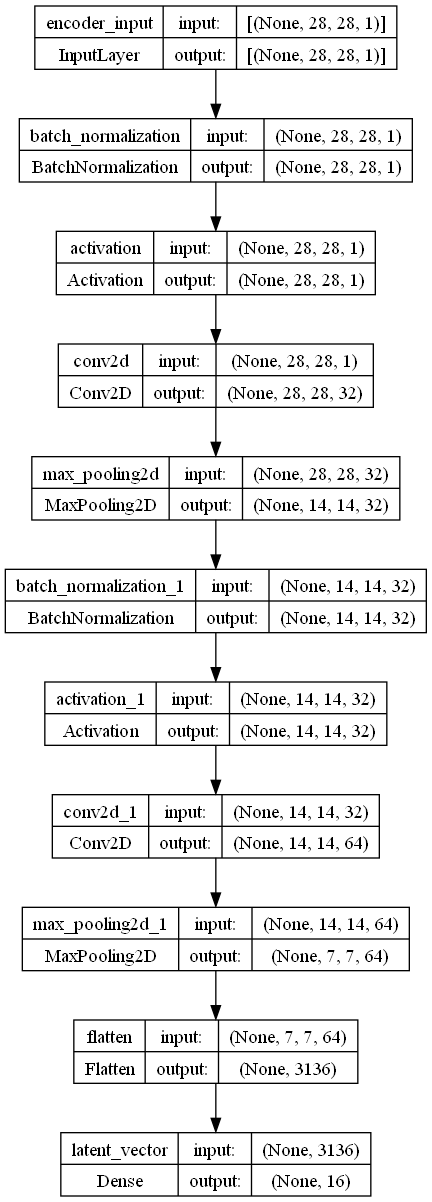

In [5]:
plot_model(encoder, to_file='classifier-encoder.png', show_shapes=True)

In [6]:
# 2. 디코더모형

latent_inputs = Input(shape=(latent_dim,), name='decoder_input')

x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = UpSampling2D()(x)
    filters = int(filters / 2)

x = Conv2DTranspose(filters=1, kernel_size=kernel_size, padding='same')(x)
outputs = Activation('sigmoid', name='decoder_output')(x)
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 16)]              0         
                                                                 
 dense (Dense)               (None, 3136)              53312     
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 batch_normalization_2 (Batc  (None, 7, 7, 64)         256       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 64)         36928     
 nspose)                                                   

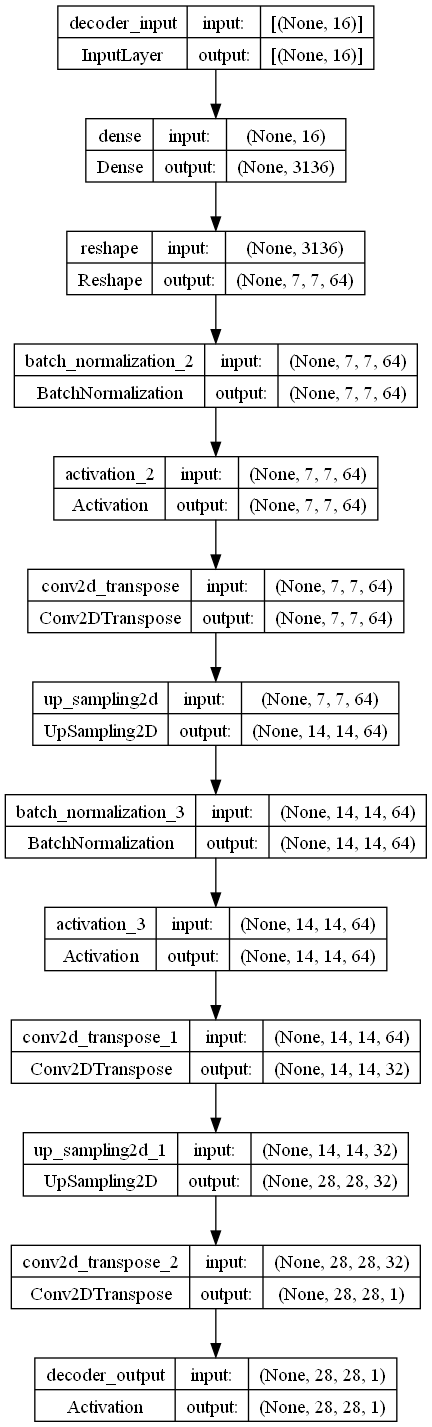

In [7]:
plot_model(decoder, to_file='classifier-decoder.png', show_shapes=True)

In [8]:
# 3. 분류기 모형

latent_inputs = Input(shape = (latent_dim,), name='classifier_input')
x = Dense(512)(latent_inputs)
x = Activation('relu')(x)
x = Dropout(0.4)(x)
x = Dense(256)(x)
x = Activation('relu')(x)
x = Dropout(0.4)(x)
x = Dense(num_labels)(x)
classifier_outputs = Activation('softmax', name='classifier_output')(x)
classifier = Model(latent_inputs, classifier_outputs, name='classifier')
classifier.summary()

Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 classifier_input (InputLaye  [(None, 16)]             0         
 r)                                                              
                                                                 
 dense_1 (Dense)             (None, 512)               8704      
                                                                 
 activation_4 (Activation)   (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 activation_5 (Activation)   (None, 256)               0         
                                                        

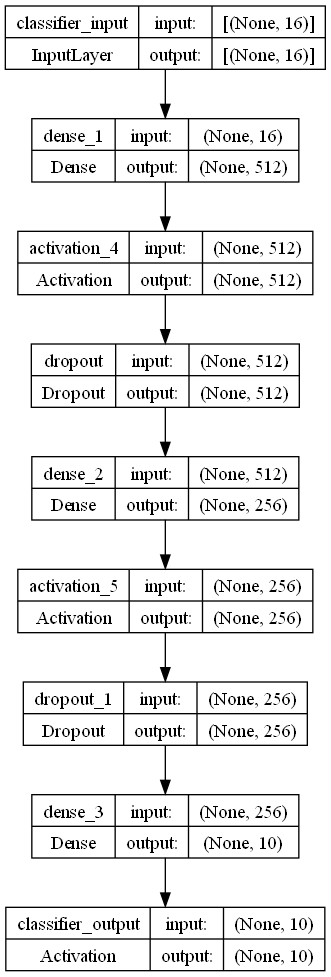

In [9]:
plot_model(classifier, to_file='classifier.png', show_shapes=True)

In [10]:
# autoencoder 모형  Autoencoder = Encoder + Classifier / decoder

autoencoder = Model(inputs, [classifier(encoder(inputs)), decoder(encoder(inputs))], name='autodecoder')
autoencoder.compile(loss=['categorical_crossentropy', 'mse'],
                    optimizer='adam',
                    metrics=['accuracy', 'mse'])                    
autoencoder.summary()

Model: "autodecoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           (None, 16)           69140       ['encoder_input[0][0]',          
                                                                  'encoder_input[0][0]']          
                                                                                                  
 classifier (Functional)        (None, 10)           142602      ['encoder[0][0]']                
                                                                                                  
 decoder (Functional)           (None, 28, 28, 1)    109505      ['encoder[1][0]']      

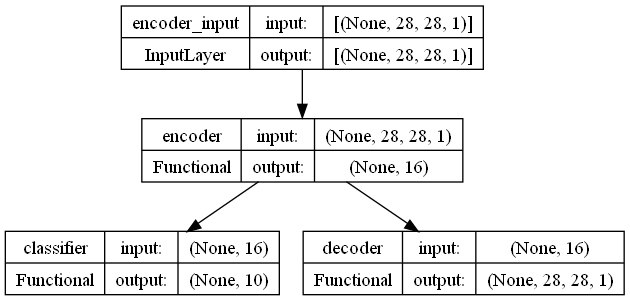

In [11]:
plot_model(autoencoder, to_file='classifier-autoencoder.png', show_shapes=True)


In [12]:
autoencoder.fit(x_tr, [y_tr, x_tr], validation_data=(x_ts, [y_ts, x_ts]), epochs=2, batch_size=batch_size,
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])


Epoch 1/2
469/469 [==============================] - 42s 32ms/step - loss: 0.2390 - classifier_loss: 0.2047 - decoder_loss: 0.0342 - classifier_accuracy: 0.9363 - classifier_mse: 0.0092 - decoder_accuracy: 0.8018 - decoder_mse: 0.0342 - val_loss: 0.0856 - val_classifier_loss: 0.0609 - val_decoder_loss: 0.0246 - val_classifier_accuracy: 0.9805 - val_classifier_mse: 0.0030 - val_decoder_accuracy: 0.8025 - val_decoder_mse: 0.0246
Epoch 2/2
469/469 [==============================] - 14s 30ms/step - loss: 0.0945 - classifier_loss: 0.0725 - decoder_loss: 0.0221 - classifier_accuracy: 0.9783 - classifier_mse: 0.0034 - decoder_accuracy: 0.8082 - decoder_mse: 0.0221 - val_loss: 0.0718 - val_classifier_loss: 0.0509 - val_decoder_loss: 0.0209 - val_classifier_accuracy: 0.9841 - val_classifier_mse: 0.0024 - val_decoder_accuracy: 0.8064 - val_decoder_mse: 0.0209


In [13]:
y_predicted, x_decoded = autoencoder.predict(x_ts)
print(np.argmax(y_predicted[:8], axis=1))

313/313 [==============================] - 2s 4ms/step
[7 2 1 0 4 1 4 9]


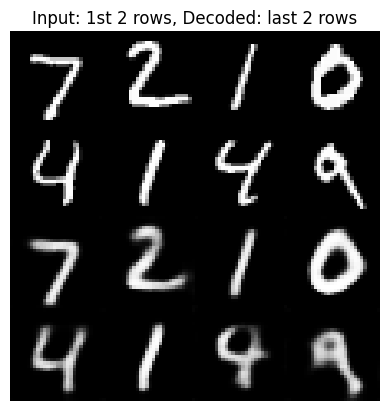

In [14]:
imgs = np.concatenate([x_ts[:8], x_decoded[:8]])
imgs = imgs.reshape((4,4,image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.show()